# XCEPTION + DEC Model on Galaxy Zoo Dataset

This notebook loads the xception model and tries to extract features from the Xception Model for all the galaxy zoo images. Then it invokes a DEC model on top of the features extracted to perform the required clustering. This notebook acts as a step by step guide through the whole process and also as a way of performing the experiment for the current research of clustering galaxies.

### Importing required Libaries

Importing the required libraries and modules so that they can be used in the notebook

In [7]:
import tensorflow as tf
import keras.backend as K
import numpy as np
import pandas as pd
# loading the requirements for the Xception model
from keras.applications.xception import Xception
from keras.applications.xception import absolute_import, decode_predictions, preprocess_input
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
# Loading the DEC module cloned from github
from DEC.model import *
from DEC.metrics import *
from xception_dec_datagenerator import XceptionDataGenerator
# Importing the utilities
from utils.file_utils import *
from PIL import Image
# Using scikit-image  resize function for resizing the image from original size to 224 X 224
# from skimage.transform import resize
# Train Test split from sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from shutil import copy2
# For visualization of images and for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [8]:
import warnings
warnings.filterwarnings('ignore')

### Xception Model

First we load the Xception model into the computer memory using the Keras library. Because we are focusing on extracting features from the model we do not include the topmost layer. However we do use the imagenet weights for the model. Also because we want a 1-D vector form of the features we do use the pooling layer at the end.

In [9]:
input_tensor_shape = (224, 224, 3)
base_xception_model = Xception(weights = 'imagenet', input_shape = input_tensor_shape, include_top = False, pooling='avg')
base_xception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

The input shape of our base xception model is: 224 X 224 X 3. That is a 3 channel square image with side 224 pixels.
The output shape of the base xception model is: 2048 X 1. It is a 1-D vector representing the features learned by the model

### Loading the Galaxy Zoo data

We now start loading the galaxy zoo data into memory. First we load the label file and then start loading the corresponding images such that we can assign the corresponding label to them

In [10]:
all_labels = pd.read_csv(f'../data/galaxy_zoo/training_solutions_rev1.csv')
all_labels.head()

,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [11]:
# Assuming the follwing column names:
elliptical_galaxy_col_name = 'Class1.1'
spiral_galaxy_col_name = 'Class1.2'

# elliptical_galaxy_ids = pd.Series(all_labels[all_labels[elliptical_galaxy_col_name] > all_labels[spiral_galaxy_col_name]]['GalaxyID'], dtype=str)
elliptical_galaxy_ids = pd.Series(all_labels[all_labels[elliptical_galaxy_col_name] >= 0.5]['GalaxyID'], dtype=str)
# spiral_galaxy_ids = pd.Series(all_labels[all_labels[spiral_galaxy_col_name] > all_labels[elliptical_galaxy_col_name]]['GalaxyID'], dtype=str)
spiral_galaxy_ids = pd.Series(all_labels[all_labels[spiral_galaxy_col_name] > 0.5]['GalaxyID'], dtype=str)

In [12]:
# Finding the number of images for each type of galaxy
print(f'Number Elliptical Galaxies: {elliptical_galaxy_ids.shape[0]}')
print(f'Number Spiral Galaxies: {spiral_galaxy_ids.shape[0]}')

Number Elliptical Galaxies: 25868
Number Spiral Galaxies: 34105


### Data Validation

Validate whether all the images are in the required place of the training and the testing directories. Make sure we copy all the required images from the galaxy zoo data lake to the correct place and then define all the generators

In [16]:
data_lake_path = f'../data/galaxy_zoo/images_training_rev1/'
print(exist_directory(data_lake_path))
training_directory_path = f'../data/xception_clustering/training/'
testing_directory_path = f'../data/xception_clustering/testing/'
print(exist_directory(training_directory_path), exist_directory(testing_directory_path))

True
True True


In [17]:
# Get file names for the different types of galaxies from the dataframe that are also present in the dataset
image_extension = '.jpg'
all_image_files = get_file_nms(data_lake_path, image_extension)
print(len(all_image_files))
common_spiral_galaxy_ids = list(set(spiral_galaxy_ids).intersection(all_image_files))
common_elliptical_galaxy_ids = list(set(elliptical_galaxy_ids).intersection(all_image_files))
# Finding the number of images for each type of galaxy after finding the common images and list
print(f'Number of common Elliptical Galaxies: {len(common_elliptical_galaxy_ids)}')
print(f'Number of common Spiral Galaxies: {len(common_spiral_galaxy_ids)}')

61578
Number of common Elliptical Galaxies: 25868
Number of common Spiral Galaxies: 34105


In [18]:
# Getting the files already in the training and testing folders respectively
spiral_training_directory_path = construct_path(training_directory_path, 'spiral')
elliptical_training_directory_path = construct_path(training_directory_path, 'elliptical')
spiral_testing_directory_path = construct_path(testing_directory_path, 'spiral')
elliptical_testing_directory_path = construct_path(testing_directory_path, 'elliptical')
elliptical_training_files = get_file_nms(elliptical_training_directory_path, image_extension)
spiral_training_files = get_file_nms(spiral_training_directory_path, image_extension)
elliptical_testing_files = get_file_nms(elliptical_testing_directory_path, image_extension)
spiral_testing_files = get_file_nms(spiral_testing_directory_path, image_extension)
# Finding the number of images for each type of galaxy after finding the common images and list
print(f'Number of already present Training Elliptical Galaxies: {len(elliptical_training_files)}')
print(f'Number of already present Training Spiral Galaxies: {len(spiral_training_files)}')
print(f'Number of already present Testing Elliptical Galaxies: {len(elliptical_testing_files)}')
print(f'Number of already present Testing Spiral Galaxies: {len(spiral_testing_files)}')

Number of already present Training Elliptical Galaxies: 25868
Number of already present Training Spiral Galaxies: 34105
Number of already present Testing Elliptical Galaxies: 0
Number of already present Testing Spiral Galaxies: 0


### Data Generators

Defining the keras data generators to iterate through all the images and then essentially help in extracting the features from the images

#### Normalization | Standardization | Cropping | Resizing

In [19]:
def get_difference(orig_size, target_size):
    orig_size, target_size = list(orig_size), list(target_size)
    ret_ls = []
    for o, t in zip(orig_size, target_size):
        ret_ls.append(o - t)
    return ret_ls

def crop_image(image, orig_size, target_size):
    crop_sizes = get_difference(orig_size, target_size)
    height_dif, width_dif = crop_sizes[0] // 2, crop_sizes[1] // 2
    return image[height_dif:(height_dif + target_size[0]), width_dif:(width_dif + target_size[1]), :]

def range_scaling(image):
    old_min, old_max = 0., 255.
    new_min, new_max = -1., 1.
    return ((image - old_min)/(old_max - old_min))*(new_max - new_min) + new_min

def image_preprocessing_function(image, crop=True, range_scale=True):
    """
    image is a 3-D image tensor (numpy array).
    """
    target_image_size = input_tensor_shape
    if crop:
        cropped_image = crop_image(image, image.shape, target_image_size)
    else:
        cropped_image = image
        
    if range_scale:
        final_image = range_scaling(cropped_image)
    else:
        final_image = cropped_image
    return final_image

#### Feature Extraction

In [19]:
%%time
generator_batch_size = 64
image_generator = ImageDataGenerator(preprocessing_function=image_preprocessing_function)
training_generator = image_generator.flow_from_directory(training_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)
testing_generator = image_generator.flow_from_directory(testing_directory_path, target_size = input_tensor_shape[:2], 
                                                         class_mode='binary', batch_size=generator_batch_size)

Found 59973 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
CPU times: user 2.8 s, sys: 584 ms, total: 3.38 s
Wall time: 2.6 s


In [20]:
%%time
n_train_examples = (len(training_generator.filenames)//generator_batch_size) * generator_batch_size
train_features = np.zeros((n_train_examples, 2048))
train_labels = np.zeros(n_train_examples, dtype=int)
i = 0
for inputs_batch, labels_batch in training_generator:
    features_batch = base_xception_model.predict(inputs_batch)
    train_features[i * generator_batch_size : (i + 1) * generator_batch_size] = features_batch
    train_labels[i * generator_batch_size : (i + 1) * generator_batch_size] = labels_batch
    i += 1
    if i % 100 == 0:
        print('Number of images processed:', i * generator_batch_size)
    if i * generator_batch_size >= n_train_examples:
        break

Number of images processed: 6400
Number of images processed: 12800
Number of images processed: 19200
Number of images processed: 25600
Number of images processed: 32000
Number of images processed: 38400
Number of images processed: 44800
Number of images processed: 51200
Number of images processed: 57600
CPU times: user 11min 9s, sys: 3min 48s, total: 14min 58s
Wall time: 14min 50s


In [21]:
train_features.shape

(59968, 2048)

### Experiment A: 2048 X 4096 X 4096 X 1024 X 10

#### DEC Xception Training Regime

This part of the notebook defines the generator for the training regime of the DEC model over the features extracted from the Xception architecture

In [22]:
# Defining our DEC model
dec_model = DEC([2048, 4096, 4096, 1024, 10], n_clusters=2)
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               1024500   
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 20        
Total params: 2,297,030
Trainable params: 2,297,030
Non-trainable params: 0
_________________________________________________________________


In [23]:
results_save_dir = 'results/arch_2048_4096_4096_1024_10'
if not exist_directory(results_save_dir):
    os.makedirs(results_save_dir)

In [24]:
%%time
dec_model.pretrain(train_features, train_labels, epochs=100, save_dir=results_save_dir)

...Pretraining...
Epoch 1/100
59968/59968 [==============================] - 6s 96us/step - loss: 1.1750
        |==>  acc: 0.5434,  nmi: 0.0048  <==|
Epoch 2/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.6637
Epoch 3/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.6532
Epoch 4/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.5874
Epoch 5/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.5531
Epoch 6/100
59968/59968 [==============================] - 4s 71us/step - loss: 0.4899
Epoch 7/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.5135
Epoch 8/100
59968/59968 [==============================] - 4s 71us/step - loss: 0.4602
Epoch 9/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.4464
Epoch 10/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.4313
Epoch 11/100
59968/59968 [==============================] - 4s 70

In [25]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=32, save_dir=results_save_dir)
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 9370
Initializing cluster centers with k-means.
Iter 0: acc = 0.54756, nmi = 0.00351, ari = -0.00548  ; loss= 0
saving model to: results/crop_standardization/DEC_model_0.h5
Iter 140: acc = 0.54873, nmi = 0.00043, ari = -0.00252  ; loss= 0.0039
Iter 280: acc = 0.54627, nmi = 0.00014, ari = -0.00157  ; loss= 0.01615
Iter 420: acc = 0.54384, nmi = 0.00003, ari = -0.00081  ; loss= 0.02104
Iter 560: acc = 0.54217, nmi = 0.00003, ari = -0.00077  ; loss= 0.01325
Iter 700: acc = 0.53732, nmi = 0.00014, ari = -0.00162  ; loss= 0.00597
Iter 840: acc = 0.53702, nmi = 0.00009, ari = -0.00131  ; loss= 0.03797
Iter 980: acc = 0.53707, nmi = 0.00005, ari = -0.00101  ; loss= 0.02077
Iter 1120: acc = 0.53363, nmi = 0.00010, ari = -0.00132  ; loss= 0.04195
Iter 1260: acc = 0.53435, nmi = 0.00011, ari = -0.00138  ; loss= 0.02762
Iter 1400: acc = 0.53370, nmi = 0.00013, ari = -0.00149  ; loss= 0.05033
Iter 1540: acc = 0.53440, nmi = 0.00022, ari = -0.00197  ; loss= 0.0631

### Visualization of the features extracted by the DEC model

#### Encoder Output Features

CPU times: user 6.97 s, sys: 1.08 s, total: 8.05 s
Wall time: 6.45 s


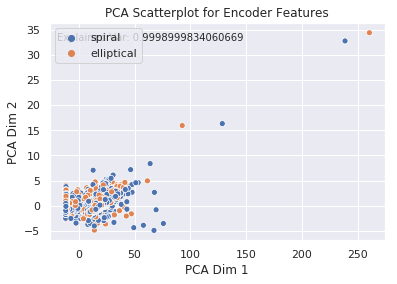

In [26]:
%%time
dec_encoder_model_pred = dec_model.encoder.predict(train_features)
pca_mod = PCA(2)
pca_mod.fit(dec_encoder_model_pred)
reduced_features = pca_mod.transform(dec_encoder_model_pred)
fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=np.where(train_labels==0, 'elliptical', 'spiral'), ax=ax)
ax.text(0.02, 0.92, f'Explained Var: {np.round(np.sum(pca_mod.explained_variance_ratio_), decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_title('PCA Scatterplot for Encoder Features')
plt.savefig(f'{results_save_dir}/encoding_pca_features.png')

#### Training Curves

In [27]:
dec_log, ptrain_log = pd.read_csv(f'{results_save_dir}/dec_log.csv'), pd.read_csv(f'{results_save_dir}/pretrain_log.csv')

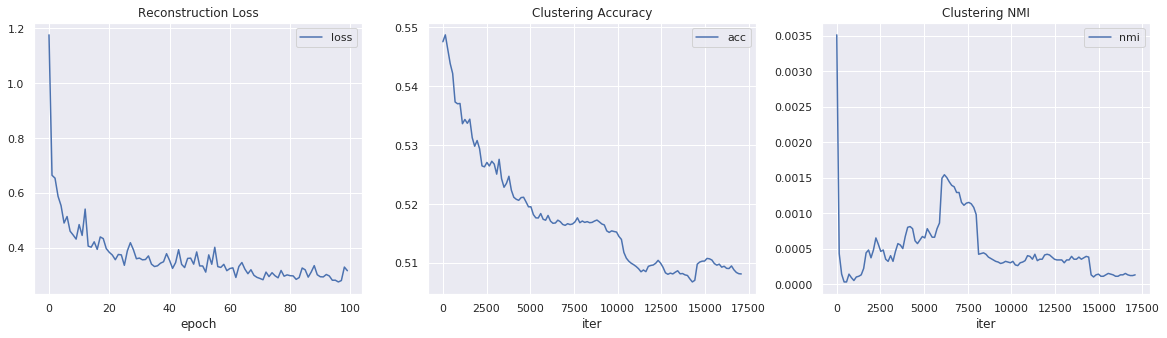

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ptrain_log.plot(x='epoch', y='loss', ax=ax[0], title='Reconstruction Loss')
dec_log.plot(x='iter', y='acc', ax=ax[1], title='Clustering Accuracy')
dec_log.plot(x='iter', y='nmi', ax=ax[-1], title='Clustering NMI')
plt.savefig(f'{results_save_dir}/training_curves.png')

### Experiment B: 2048 X 2048 X 4096 X 2048 X 10

#### DEC Xception Training Regime

This part of the notebook defines the generator for the training regime of the DEC model over the features extracted from the Xception architecture

In [22]:
# Defining our DEC model
dec_model = DEC([2048, 2048, 4096, 2048, 10], n_clusters=2)
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               1024500   
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 20        
Total params: 2,297,030
Trainable params: 2,297,030
Non-trainable params: 0
_________________________________________________________________


In [23]:
results_save_dir = 'results/arch_2048_2048_4096_2048_10'
if not exist_directory(results_save_dir):
    os.makedirs(results_save_dir)

In [24]:
%%time
dec_model.pretrain(train_features, train_labels, epochs=100, save_dir=results_save_dir)

...Pretraining...
Epoch 1/100
59968/59968 [==============================] - 6s 96us/step - loss: 1.1750
        |==>  acc: 0.5434,  nmi: 0.0048  <==|
Epoch 2/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.6637
Epoch 3/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.6532
Epoch 4/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.5874
Epoch 5/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.5531
Epoch 6/100
59968/59968 [==============================] - 4s 71us/step - loss: 0.4899
Epoch 7/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.5135
Epoch 8/100
59968/59968 [==============================] - 4s 71us/step - loss: 0.4602
Epoch 9/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.4464
Epoch 10/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.4313
Epoch 11/100
59968/59968 [==============================] - 4s 70

In [25]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=32, save_dir=results_save_dir)
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 9370
Initializing cluster centers with k-means.
Iter 0: acc = 0.54756, nmi = 0.00351, ari = -0.00548  ; loss= 0
saving model to: results/crop_standardization/DEC_model_0.h5
Iter 140: acc = 0.54873, nmi = 0.00043, ari = -0.00252  ; loss= 0.0039
Iter 280: acc = 0.54627, nmi = 0.00014, ari = -0.00157  ; loss= 0.01615
Iter 420: acc = 0.54384, nmi = 0.00003, ari = -0.00081  ; loss= 0.02104
Iter 560: acc = 0.54217, nmi = 0.00003, ari = -0.00077  ; loss= 0.01325
Iter 700: acc = 0.53732, nmi = 0.00014, ari = -0.00162  ; loss= 0.00597
Iter 840: acc = 0.53702, nmi = 0.00009, ari = -0.00131  ; loss= 0.03797
Iter 980: acc = 0.53707, nmi = 0.00005, ari = -0.00101  ; loss= 0.02077
Iter 1120: acc = 0.53363, nmi = 0.00010, ari = -0.00132  ; loss= 0.04195
Iter 1260: acc = 0.53435, nmi = 0.00011, ari = -0.00138  ; loss= 0.02762
Iter 1400: acc = 0.53370, nmi = 0.00013, ari = -0.00149  ; loss= 0.05033
Iter 1540: acc = 0.53440, nmi = 0.00022, ari = -0.00197  ; loss= 0.0631

### Visualization of the features extracted by the DEC model

#### Encoder Output Features

CPU times: user 6.97 s, sys: 1.08 s, total: 8.05 s
Wall time: 6.45 s


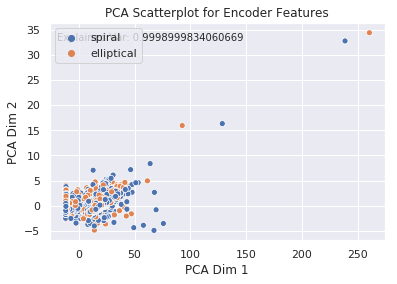

In [26]:
%%time
dec_encoder_model_pred = dec_model.encoder.predict(train_features)
pca_mod = PCA(2)
pca_mod.fit(dec_encoder_model_pred)
reduced_features = pca_mod.transform(dec_encoder_model_pred)
fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=np.where(train_labels==0, 'elliptical', 'spiral'), ax=ax)
ax.text(0.02, 0.92, f'Explained Var: {np.round(np.sum(pca_mod.explained_variance_ratio_), decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_title('PCA Scatterplot for Encoder Features')
plt.savefig(f'{results_save_dir}/encoding_pca_features.png')

#### Training Curves

In [27]:
dec_log, ptrain_log = pd.read_csv(f'{results_save_dir}/dec_log.csv'), pd.read_csv(f'{results_save_dir}/pretrain_log.csv')

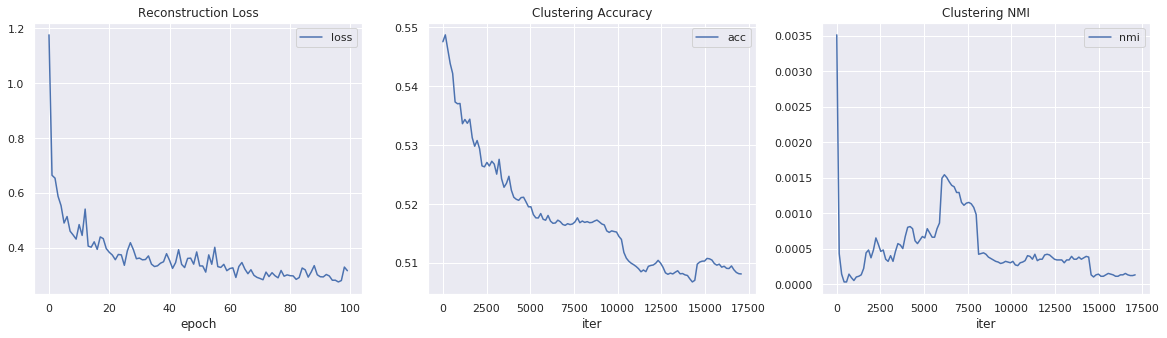

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ptrain_log.plot(x='epoch', y='loss', ax=ax[0], title='Reconstruction Loss')
dec_log.plot(x='iter', y='acc', ax=ax[1], title='Clustering Accuracy')
dec_log.plot(x='iter', y='nmi', ax=ax[-1], title='Clustering NMI')
plt.savefig(f'{results_save_dir}/training_curves.png')

### Experiment C: 2048 X 4096 X 2048 X 1024 X 10

#### DEC Xception Training Regime

This part of the notebook defines the generator for the training regime of the DEC model over the features extracted from the Xception architecture

In [22]:
# Defining our DEC model
dec_model = DEC([2048, 4096, 2048, 1024, 10], n_clusters=2)
dec_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2048)              0         
_________________________________________________________________
encoder_0 (Dense)            (None, 500)               1024500   
_________________________________________________________________
encoder_1 (Dense)            (None, 500)               250500    
_________________________________________________________________
encoder_2 (Dense)            (None, 2000)              1002000   
_________________________________________________________________
encoder_3 (Dense)            (None, 10)                20010     
_________________________________________________________________
clustering (ClusteringLayer) (None, 2)                 20        
Total params: 2,297,030
Trainable params: 2,297,030
Non-trainable params: 0
_________________________________________________________________


In [23]:
results_save_dir = 'results/arch_2048_4096_2048_1024_10'
if not exist_directory(results_save_dir):
    os.makedirs(results_save_dir)

In [24]:
%%time
dec_model.pretrain(train_features, train_labels, epochs=100, save_dir=results_save_dir)

...Pretraining...
Epoch 1/100
59968/59968 [==============================] - 6s 96us/step - loss: 1.1750
        |==>  acc: 0.5434,  nmi: 0.0048  <==|
Epoch 2/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.6637
Epoch 3/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.6532
Epoch 4/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.5874
Epoch 5/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.5531
Epoch 6/100
59968/59968 [==============================] - 4s 71us/step - loss: 0.4899
Epoch 7/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.5135
Epoch 8/100
59968/59968 [==============================] - 4s 71us/step - loss: 0.4602
Epoch 9/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.4464
Epoch 10/100
59968/59968 [==============================] - 4s 70us/step - loss: 0.4313
Epoch 11/100
59968/59968 [==============================] - 4s 70

In [25]:
%%time
dec_model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
y_pred = dec_model.fit(train_features, y=train_labels, batch_size=32, save_dir=results_save_dir)
print('acc:', metrics.acc(train_labels, y_pred))

Update interval 140
Save interval 9370
Initializing cluster centers with k-means.
Iter 0: acc = 0.54756, nmi = 0.00351, ari = -0.00548  ; loss= 0
saving model to: results/crop_standardization/DEC_model_0.h5
Iter 140: acc = 0.54873, nmi = 0.00043, ari = -0.00252  ; loss= 0.0039
Iter 280: acc = 0.54627, nmi = 0.00014, ari = -0.00157  ; loss= 0.01615
Iter 420: acc = 0.54384, nmi = 0.00003, ari = -0.00081  ; loss= 0.02104
Iter 560: acc = 0.54217, nmi = 0.00003, ari = -0.00077  ; loss= 0.01325
Iter 700: acc = 0.53732, nmi = 0.00014, ari = -0.00162  ; loss= 0.00597
Iter 840: acc = 0.53702, nmi = 0.00009, ari = -0.00131  ; loss= 0.03797
Iter 980: acc = 0.53707, nmi = 0.00005, ari = -0.00101  ; loss= 0.02077
Iter 1120: acc = 0.53363, nmi = 0.00010, ari = -0.00132  ; loss= 0.04195
Iter 1260: acc = 0.53435, nmi = 0.00011, ari = -0.00138  ; loss= 0.02762
Iter 1400: acc = 0.53370, nmi = 0.00013, ari = -0.00149  ; loss= 0.05033
Iter 1540: acc = 0.53440, nmi = 0.00022, ari = -0.00197  ; loss= 0.0631

### Visualization of the features extracted by the DEC model

#### Encoder Output Features

CPU times: user 6.97 s, sys: 1.08 s, total: 8.05 s
Wall time: 6.45 s


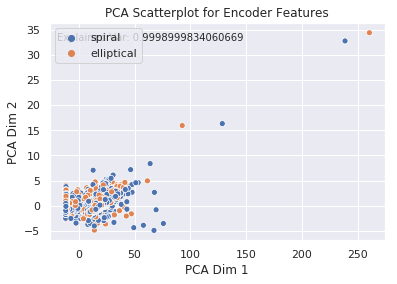

In [26]:
%%time
dec_encoder_model_pred = dec_model.encoder.predict(train_features)
pca_mod = PCA(2)
pca_mod.fit(dec_encoder_model_pred)
reduced_features = pca_mod.transform(dec_encoder_model_pred)
fig, ax = plt.subplots(1, 1)
sns.scatterplot(reduced_features[:, 0], reduced_features[:, 1], 
                hue=np.where(train_labels==0, 'elliptical', 'spiral'), ax=ax)
ax.text(0.02, 0.92, f'Explained Var: {np.round(np.sum(pca_mod.explained_variance_ratio_), decimals=4)}', 
        transform=ax.transAxes)
ax.set_xlabel('PCA Dim 1')
ax.set_ylabel('PCA Dim 2')
ax.set_title('PCA Scatterplot for Encoder Features')
plt.savefig(f'{results_save_dir}/encoding_pca_features.png')

#### Training Curves

In [27]:
dec_log, ptrain_log = pd.read_csv(f'{results_save_dir}/dec_log.csv'), pd.read_csv(f'{results_save_dir}/pretrain_log.csv')

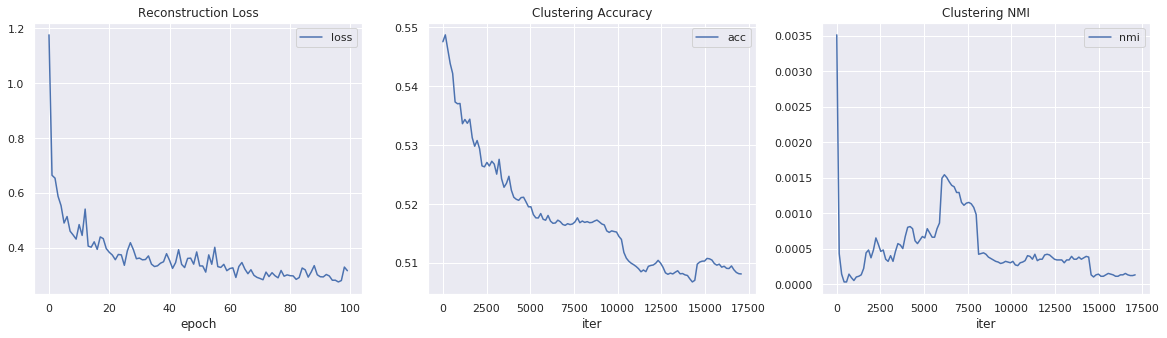

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ptrain_log.plot(x='epoch', y='loss', ax=ax[0], title='Reconstruction Loss')
dec_log.plot(x='iter', y='acc', ax=ax[1], title='Clustering Accuracy')
dec_log.plot(x='iter', y='nmi', ax=ax[-1], title='Clustering NMI')
plt.savefig(f'{results_save_dir}/training_curves.png')